In [45]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report


In [47]:
data_path = Path("WA_Fn-UseC_-Telco-Customer-Churn.csv")
df = pd.read_csv(data_path)
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
Data Cleaning

In [49]:
df["TotalCharges"] = df["TotalCharges"].replace(" ", pd.NA)
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df = df.dropna(subset=["TotalCharges"])

df["Churn"] = (df["Churn"] == "Yes").astype(int)

if "customerID" in df.columns:
    df = df.drop(columns=["customerID"])

df.describe(include="all")

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
count,7032,7032.000000,7032,7032,7032.000000,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032.000000,7032.000000,7032.000000
unique,2,NaN,2,2,NaN,2,3,3,3,3,3,3,3,3,3,2,4,NaN,NaN,NaN
top,Male,NaN,No,No,NaN,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,NaN,NaN,NaN
freq,3549,NaN,3639,4933,NaN,6352,3385,3096,3497,3087,3094,3472,2809,2781,3875,4168,2365,NaN,NaN,NaN
mean,NaN,0.162400,NaN,NaN,32.421786,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.798208,2283.300441,0.265785
std,NaN,0.368844,NaN,NaN,24.545260,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.085974,2266.771362,0.441782
min,NaN,0.000000,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,18.800000,0.000000
25%,NaN,0.000000,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.587500,401.450000,0.000000
50%,NaN,0.000000,NaN,NaN,29.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,1397.475000,0.000000
75%,NaN,0.000000,NaN,NaN,55.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.862500,3794.737500,1.000000


Target Distribution

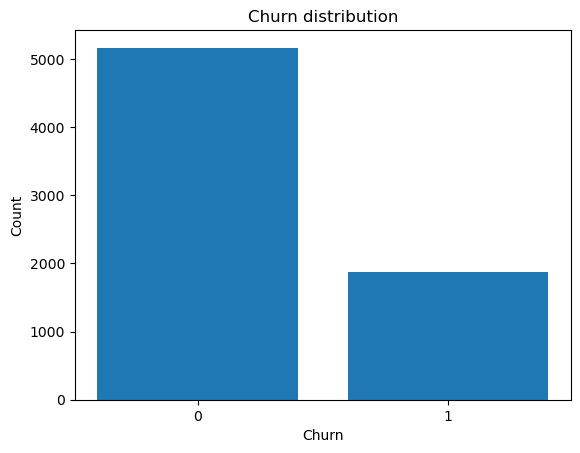

In [51]:
churn_counts = df["Churn"].value_counts().sort_index()
plt.figure()
plt.bar(churn_counts.index.astype(str), churn_counts.values)
plt.xlabel("Churn")
plt.ylabel("Count")
plt.title("Churn distribution")
plt.show()


Train/validation Split

In [53]:
X = df.drop(columns=["Churn"])
y = df["Churn"]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object", "bool"]).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)


Model 1 :Logistic Regression

In [79]:

logreg = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", LogisticRegression(max_iter=1000)),
    ]
)

logreg.fit(X_train, y_train)
y_val_pred_proba = logreg.predict_proba(X_val)[:, 1]
logreg_auc = roc_auc_score(y_val, y_val_pred_proba)
print("Logistic Regression AUC:", round(logreg_auc, 3))

Logistic Regression AUC: 0.836


In [63]:
logreg = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", LogisticRegression(max_iter=1000)),
    ]
)


In [67]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", LogisticRegression(max_iter=2000, solver="lbfgs")),
    ]
)


In [77]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object", "bool"]).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)


In [75]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

logreg = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", LogisticRegression(
            solver="liblinear",   # <-- IMPORTANT: NOT lbfgs
            max_iter=1000,
        )),
    ]
)

logreg.fit(X_train, y_train)
y_val_pred_proba = logreg.predict_proba(X_val)[:, 1]
logreg_auc = roc_auc_score(y_val, y_val_pred_proba)
print("Logistic Regression AUC:", round(logreg_auc, 3))


Logistic Regression AUC: 0.836


In [57]:
print("y_train value counts:")
print(y_train.value_counts())

print("\ny value counts (full dataset):")
print(y.value_counts())


y_train value counts:
Churn
0    4130
1    1495
Name: count, dtype: int64

y value counts (full dataset):
Churn
0    5163
1    1869
Name: count, dtype: int64


Model 2:Random forest(Tree-based)

In [59]:
rf = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", RandomForestClassifier(
            n_estimators=300,
            max_depth=8,
            random_state=42,
            n_jobs=-1
        )),
    ]
)

rf.fit(X_train, y_train)
y_val_pred_proba_rf = rf.predict_proba(X_val)[:, 1]
rf_auc = roc_auc_score(y_val, y_val_pred_proba_rf)
print("Random Forest AUC:", round(rf_auc, 3))


Random Forest AUC: 0.835


In [ ]:
featur importance (random Forest)

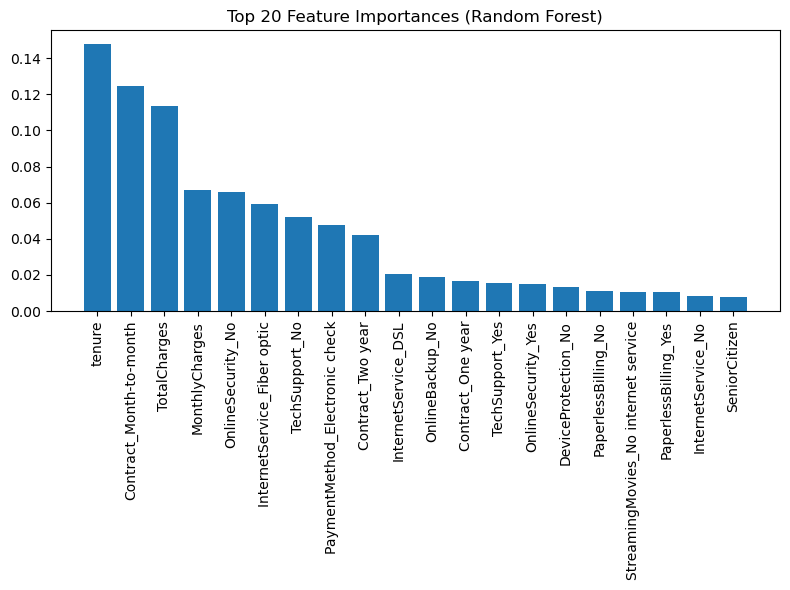

In [61]:
# Fit RF on full data for feature importances
rf_full = RandomForestClassifier(
    n_estimators=300,
    max_depth=8,
    random_state=42,
    n_jobs=-1
)

# One-hot encode separately for importance visualization
encoder = OneHotEncoder(handle_unknown="ignore")
X_cat = encoder.fit_transform(X[categorical_features])
X_num = X[numeric_features].to_numpy()

import numpy as np
from scipy import sparse

X_full = sparse.hstack([X_num, X_cat])
rf_full.fit(X_full, y)

# Construct feature names
cat_feature_names = encoder.get_feature_names_out(categorical_features)
feature_names = list(numeric_features) + list(cat_feature_names)

importances = rf_full.feature_importances_
indices = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(8, 6))
plt.bar(range(len(indices)), importances[indices])
plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=90)
plt.title("Top 20 Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()
